# STOMP execution

Here we run the STOMP progression experiments integrated.

In [10]:
import matplotlib.pyplot as plt
import numpy as np

from common.utils import get_progress_bar
from gridworld.gridworld import GridWorld
from gridworld.room_design import stomp_two_room_design as room_design
from stomp.framework import STOMP

In [11]:
%load_ext autoreload
%autoreload 1
%aimport stomp.framework
%aimport gridworld.gridworld


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
""" Experiment parameters """

num_runs = 1
number_of_steps = 50_000
number_of_lookahead_operations = 6_000


In [13]:
all_runs = []
progress_bar = get_progress_bar(num_runs)

for run in progress_bar:
    subgoal_state_idx = 30  # hallway state in TwoRooms

    env = GridWorld(room_array=room_design)
    stomp = STOMP(
        env=env,
        subgoal_states_info={subgoal_state_idx: (7, 3)},  # hallway state position in the grid
    )

    env.reset()
    option_learning_logs, options_model_learning_logs, planning_logs = stomp.execute(
        off_policy_steps=number_of_steps,
        num_lookahead_operations=number_of_lookahead_operations,
    )
    all_runs.append((option_learning_logs, options_model_learning_logs, planning_logs))

    progress_bar.refresh()


  0%|          | 0/1 [00:00<?, ?it/s]

[INFO] Starting STOMP execution...


[INFO] Learning options for subgoal 1/1


100%|██████████| 50000/50000 [00:19<00:00, 2584.52it/s]



[INFO] Learning model for option 1/5, a Primitive Action


100%|██████████| 50000/50000 [01:47<00:00, 463.32it/s]



[INFO] Learning model for option 2/5, a Primitive Action


100%|██████████| 50000/50000 [01:46<00:00, 470.58it/s]



[INFO] Learning model for option 3/5, a Primitive Action


100%|██████████| 50000/50000 [01:54<00:00, 438.04it/s]



[INFO] Learning model for option 4/5, a Primitive Action


100%|██████████| 50000/50000 [01:49<00:00, 455.33it/s]



[INFO] Learning model for option 5/5, a Full Option


100%|██████████| 50000/50000 [01:52<00:00, 443.36it/s]



[INFO] Planning with learned options and models...


100%|██████████| 6000/6000 [00:00<00:00, 20020.69it/s]


In [14]:
""" STOMP Step Logs """

# option learning
many_initial_state_estimatives = np.zeros((num_runs, number_of_steps))
many_rmse_of_state_values = np.zeros((num_runs, number_of_steps))

# model learning
many_reward_model_rmses = np.zeros((stomp.stomp_foundation.num_options, num_runs, number_of_steps))
many_transition_model_errors = np.zeros((stomp.stomp_foundation.num_options, num_runs, number_of_steps))

# planning
many_planning_estimatives = np.zeros((num_runs, number_of_lookahead_operations))

# unpack
for i, run in enumerate(all_runs):
    local_option_learning_logs = run[0]
    local_model_learning_logs = run[1]
    local_planning_logs = run[2]

    # option learning
    many_initial_state_estimatives[i] = local_option_learning_logs[0][0]
    many_rmse_of_state_values[i] = local_option_learning_logs[0][1]
    # model learning
    many_reward_model_rmses[4][i] = local_model_learning_logs[4][0]
    many_transition_model_errors[4][i] = local_model_learning_logs[4][1]
    # planning
    many_planning_estimatives[i] = local_planning_logs

assert many_initial_state_estimatives.shape == (num_runs, number_of_steps)
assert many_rmse_of_state_values.shape == (num_runs, number_of_steps)
assert many_reward_model_rmses.shape == (stomp.stomp_foundation.num_options, num_runs, number_of_steps)
assert many_transition_model_errors.shape == (stomp.stomp_foundation.num_options, num_runs, number_of_steps)
assert many_planning_estimatives.shape == (num_runs, number_of_lookahead_operations)

In [15]:
def plot_arrays(
        mean_array,
        std_array,
        plotting_info,
        additional_mean_array=None,
        additional_std_array=None
    ):
    # Create figure and axis
    fig1, ax1 = plt.subplots(figsize=(18, 6))

    # Generate x-axis points (assuming these are sequential steps/episodes)
    x = np.arange(len(mean_array))

    # Plot mean line with shaded standard deviation
    ax1.plot(x, mean_array, label="Mean", color="skyblue")
    ax1.fill_between(
        x,
        mean_array - std_array,
        mean_array + std_array,
        color="skyblue",
        alpha=0.2,
        label="Standard Deviation",
    )

    # Customize the plot
    ax1.set_xlabel(plotting_info["xlabel"])
    ax1.set_ylabel(f"{plotting_info['ylabel']}\n(Average Over 100 runs)", color="blue")

    if additional_mean_array is not None and additional_std_array is not None:
        ax2 = ax1.twinx()  # Create a second y-axis
        ax2.plot(x, additional_mean_array, color="coral")
        ax2.fill_between(
            x,
            additional_mean_array - additional_std_array,
            additional_mean_array + additional_std_array,
            color="coral",
            alpha=0.2,
        )
        ax2.set_ylabel(f"{plotting_info['additional_ylabel']}\n(Average Over 100 runs)", color="red")

    plt.title(plotting_info["title"])
    plt.tight_layout()
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

C:\Users\luizt\AppData\Local\Temp\ipykernel_20296\143101305.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


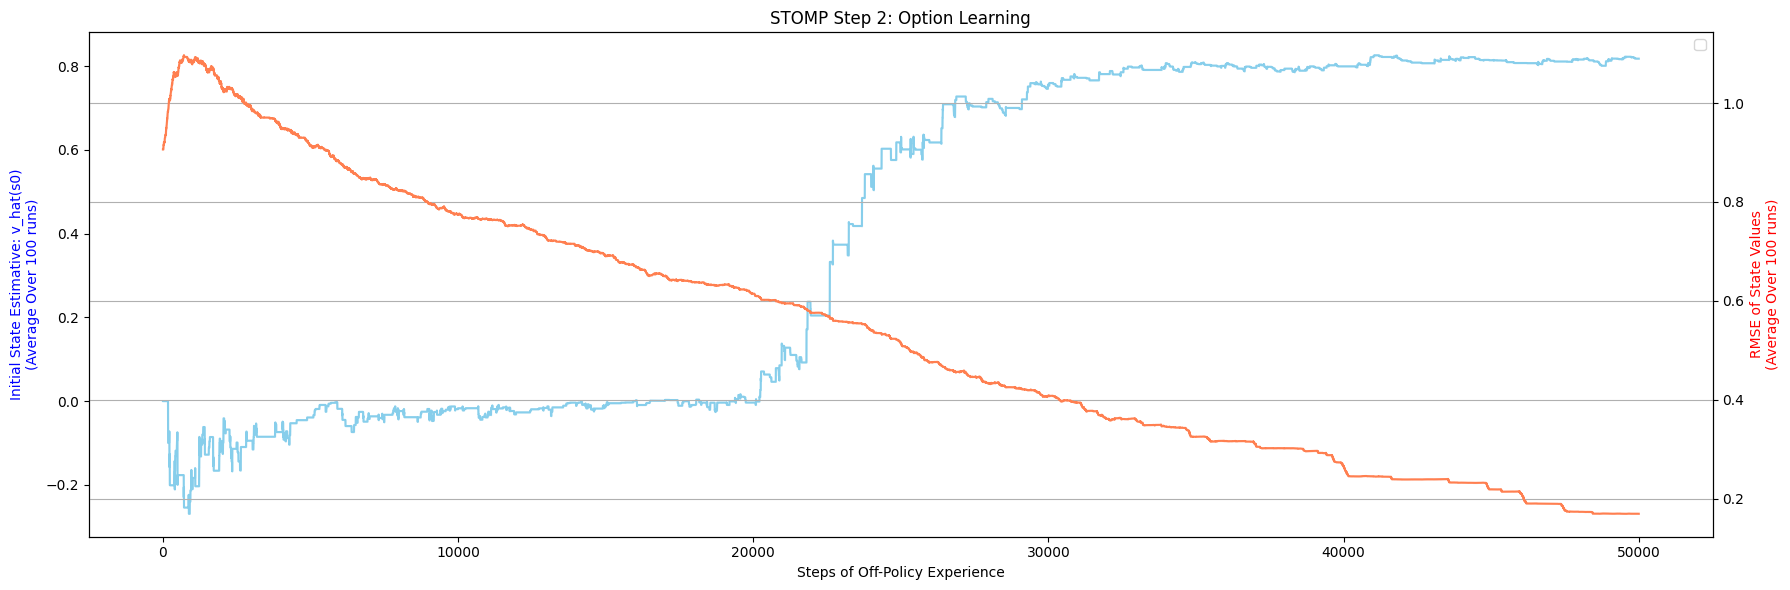

In [16]:
""" Option Learning Plot """
many_initial_state_estimatives_mean = np.mean(many_initial_state_estimatives, axis=0)
many_initial_state_estimatives_std = np.std(many_initial_state_estimatives, axis=0)

many_rmse_of_state_values_mean = np.mean(many_rmse_of_state_values, axis=0)
many_rmse_of_state_values_std = np.std(many_rmse_of_state_values, axis=0)

plot_arrays(
    many_initial_state_estimatives_mean,
    many_initial_state_estimatives_std,
    {
        "xlabel": "Steps of Off-Policy Experience",
        "ylabel": "Initial State Estimative: v_hat(s0)",
        "title": "STOMP Step 2: Option Learning",
        "additional_ylabel": "RMSE of State Values",
    },
    many_rmse_of_state_values_mean,
    many_rmse_of_state_values_std,
)

C:\Users\luizt\AppData\Local\Temp\ipykernel_20296\143101305.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


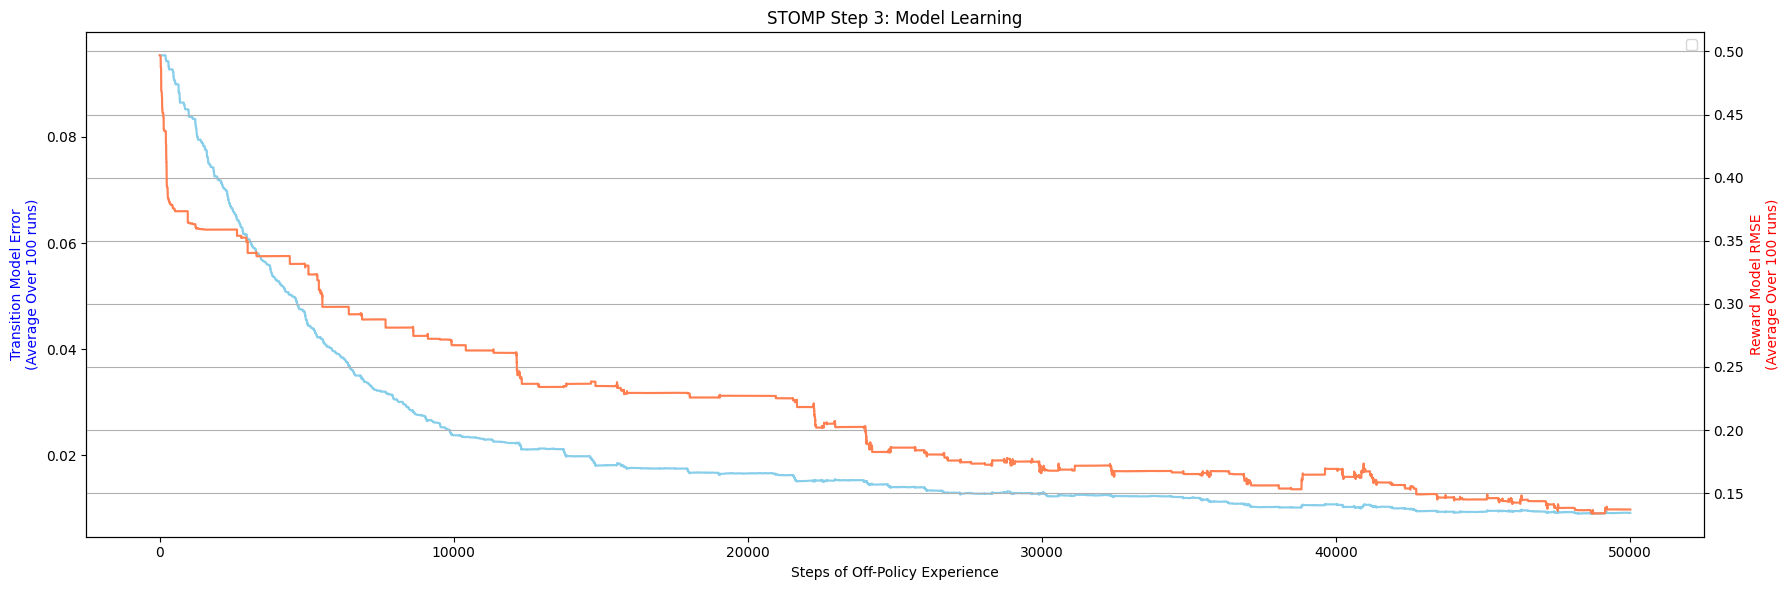

In [17]:
""" Model Learning Plot """
many_transition_model_errors_mean = np.mean(many_transition_model_errors[4], axis=0)
many_transition_model_errors_std = np.std(many_transition_model_errors[4], axis=0)

many_reward_model_rmses_mean = np.mean(many_reward_model_rmses[4], axis=0)
many_reward_model_rmses_std = np.std(many_reward_model_rmses[4], axis=0)

plot_arrays(
    many_transition_model_errors_mean,
    many_transition_model_errors_std,
    {
        "xlabel": "Steps of Off-Policy Experience",
        "ylabel": "Transition Model Error",
        "title": "STOMP Step 3: Model Learning",
        "additional_ylabel": "Reward Model RMSE",
    },
    many_reward_model_rmses_mean,
    many_reward_model_rmses_std,
)


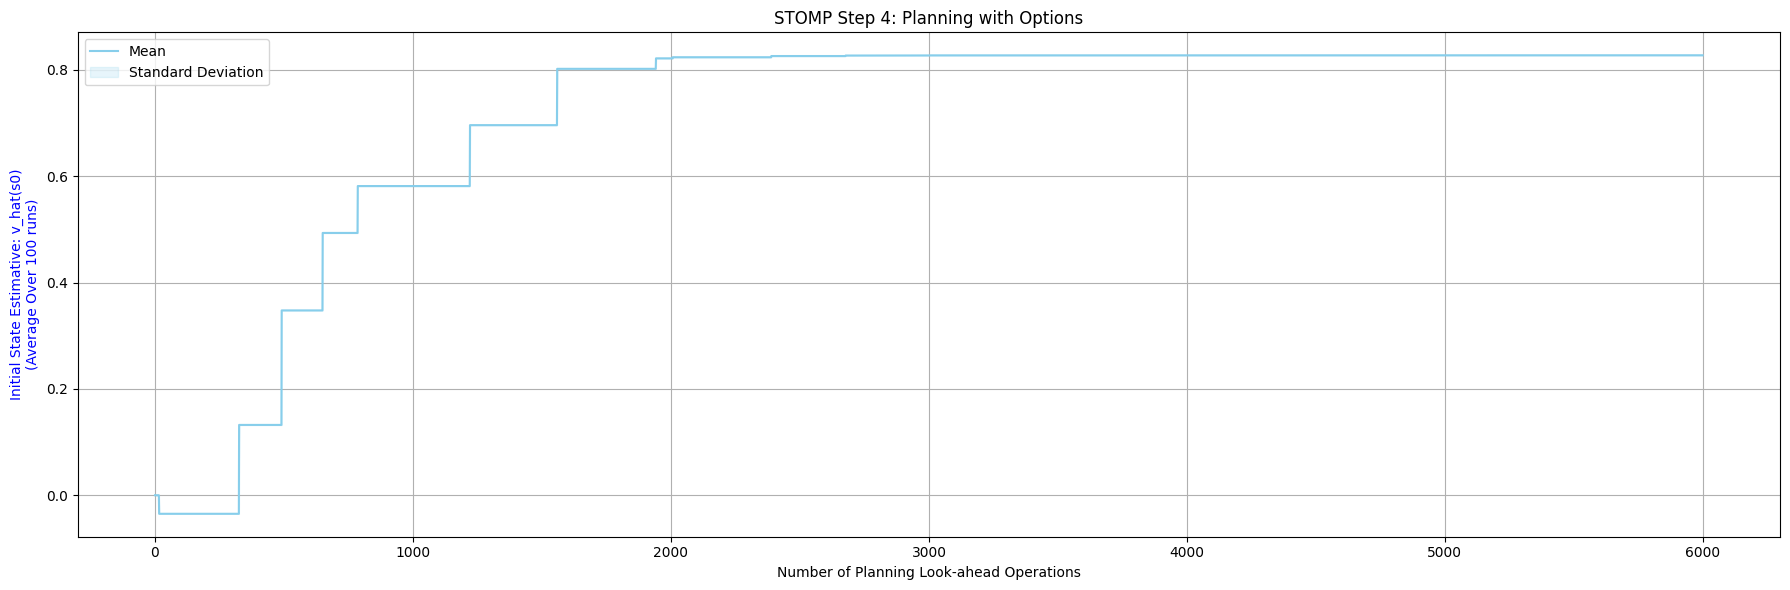

In [18]:
""" Planning Plot """
many_planning_estimatives_mean = np.mean(many_planning_estimatives, axis=0)
many_planning_estimatives_std = np.std(many_planning_estimatives, axis=0)

plot_arrays(
    many_planning_estimatives_mean,
    many_planning_estimatives_std,
    {
        "xlabel": "Number of Planning Look-ahead Operations",
        "ylabel": "Initial State Estimative: v_hat(s0)",
        "title": "STOMP Step 4: Planning with Options",
    },
)
